In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from scipy.stats import randint, uniform

Feature Engineering

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
len(df)

1338

<Axes: xlabel='age', ylabel='charges'>

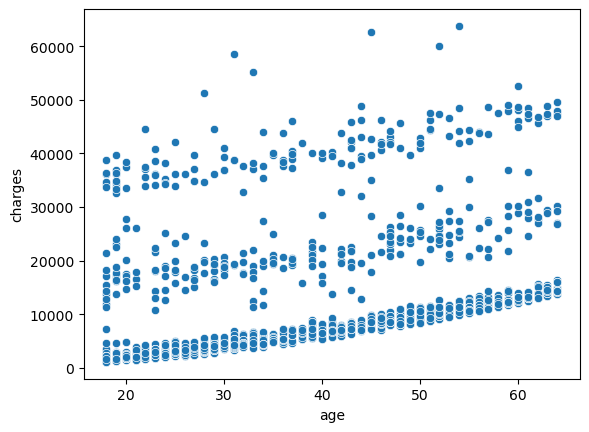

In [6]:
sns.scatterplot(x = df['age'], y = df['charges'], data=df)

In [7]:
df[(df['charges'] > 50000) & (40 > df['age'])]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209


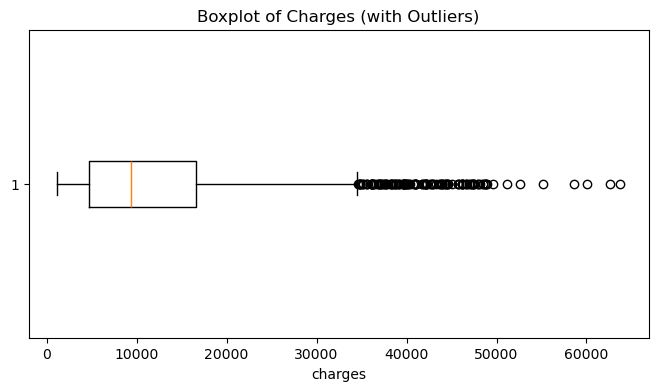

In [8]:
plt.figure(figsize=(8,4))
plt.boxplot(df['charges'], vert=False)
plt.title('Boxplot of Charges (with Outliers)')
plt.xlabel('charges')
plt.show()


In [9]:
df_model = df.copy()
df_model['sex_m'] = df_model['sex'].map({'male': 1, 'female': 0})
df_model['smoker_y'] = df_model['smoker'].map({'yes': 1, 'no': 0})

In [10]:
df_model

,age,sex,bmi,children,smoker,region,charges,sex_m,smoker_y
0,19,female,27.900,0,yes,southwest,16884.92400,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0


In [11]:
features = ['age', 'bmi', 'children', 'charges', 'sex_m', 'smoker_y']
X = df_model[features].values

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:

iso = IsolationForest(n_estimators=200, contamination=0.10, random_state=42)
iso_preds = iso.fit_predict(X_scaled)

In [14]:
df['iso_outlier'] = iso_preds == -1

df_clean = df[~df['iso_outlier']].drop(columns=['iso_outlier'])


In [15]:
df

,age,sex,bmi,children,smoker,region,charges,iso_outlier
0,19,female,27.900,0,yes,southwest,16884.92400,False
1,18,male,33.770,1,no,southeast,1725.55230,False
2,28,male,33.000,3,no,southeast,4449.46200,False
3,33,male,22.705,0,no,northwest,21984.47061,False
4,32,male,28.880,0,no,northwest,3866.85520,False
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,False
1334,18,female,31.920,0,no,northeast,2205.98080,False
1335,18,female,36.850,0,no,southeast,1629.83350,False
1336,21,female,25.800,0,no,southwest,2007.94500,False


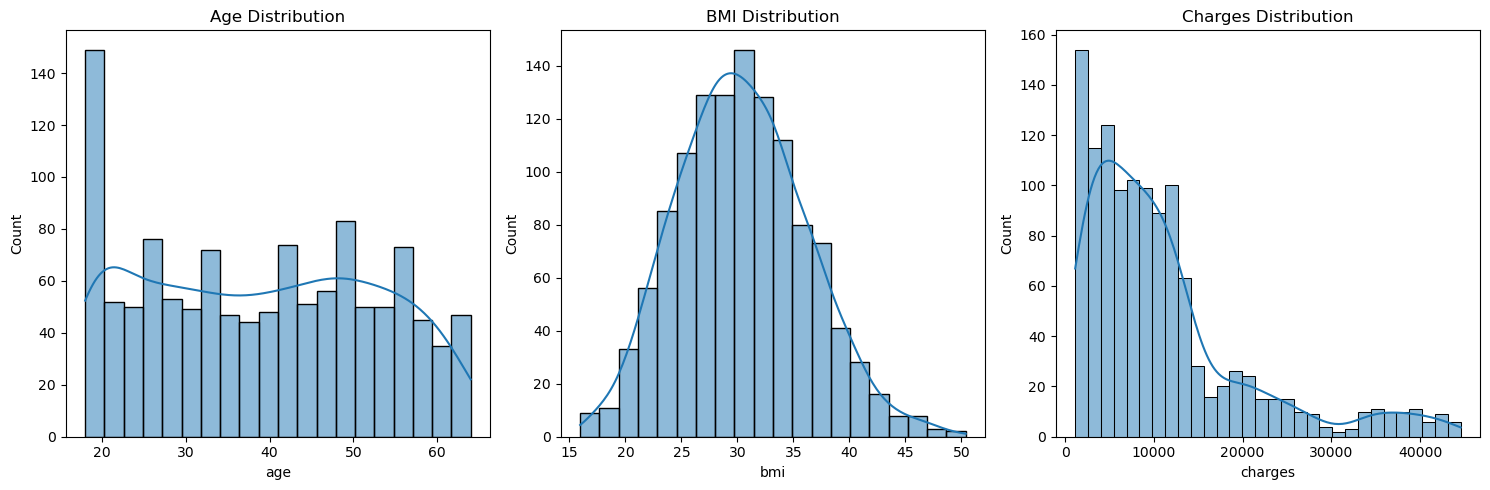

In [16]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.histplot(df_clean['age'], bins=20, kde=True)
plt.title("Age Distribution")

plt.subplot(1,3,2)
sns.histplot(df_clean['bmi'], bins=20, kde=True)
plt.title("BMI Distribution")

plt.subplot(1,3,3)
sns.histplot(df_clean['charges'], bins=30, kde=True)
plt.title("Charges Distribution")

plt.tight_layout()
plt.show()


Age --> all ages cover by 60th (uniform)
BMI --> most of the people have bmi beetween 25 and 35
Charges --> show most of the people dont pay for insurance (maybe its becuse of smoking and disease)

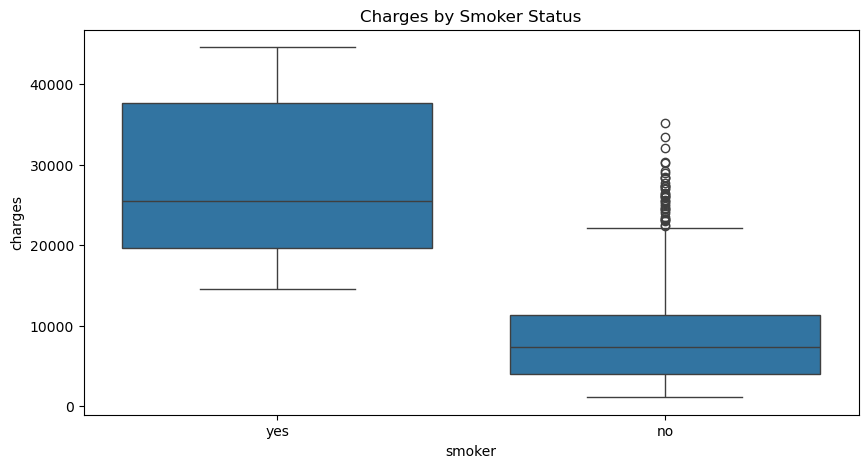

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(x="smoker", y="charges", data=df_clean)
plt.title("Charges by Smoker Status")
plt.show()


the most effective way in pay insurance is smoking or non-smoking
most of the smokers should pay more than non smokers

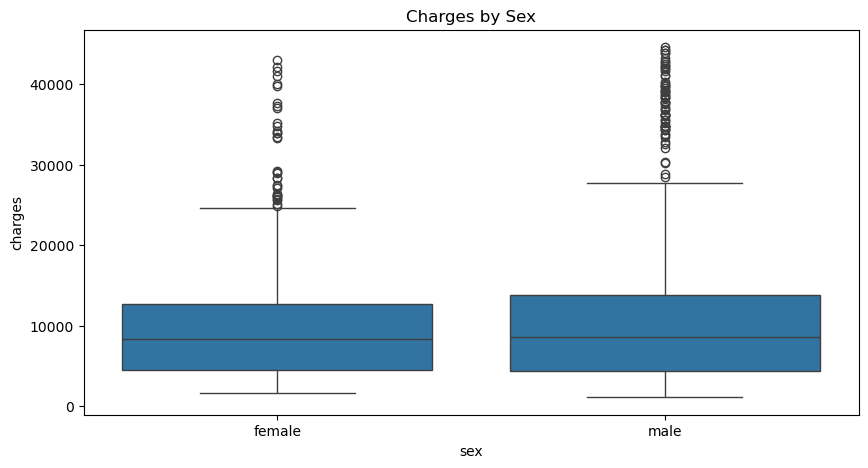

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(x="sex", y="charges", data=df_clean)
plt.title("Charges by Sex")
plt.show()


as you can see sex dont have influence on charges

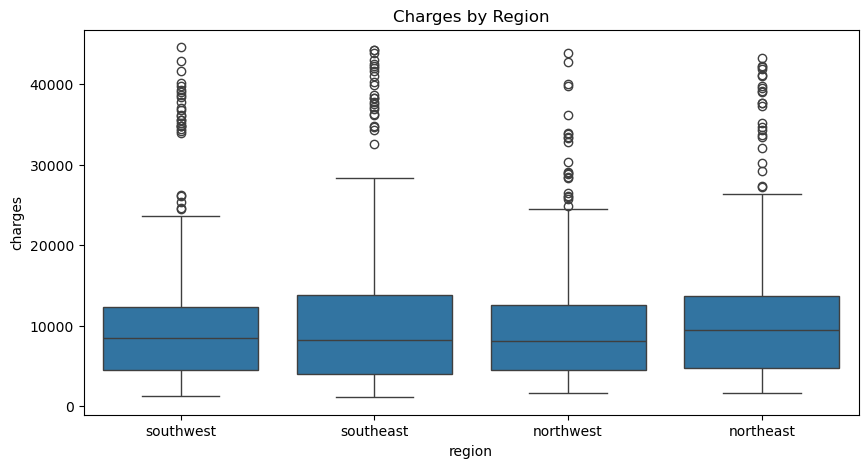

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(x="region", y="charges", data=df_clean)
plt.title("Charges by Region")
plt.show()

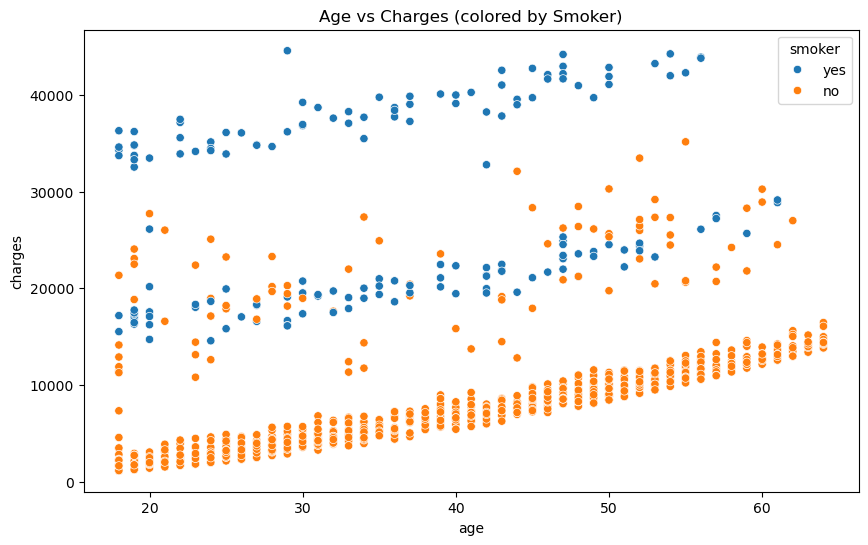

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="age", y="charges", hue="smoker", data=df_clean)
plt.title("Age vs Charges (colored by Smoker)")
plt.show()

Weak positive linear relationship → as age increases, costs tend to rise.
However, smokers (red points) show a sharp increase in costs at all ages.

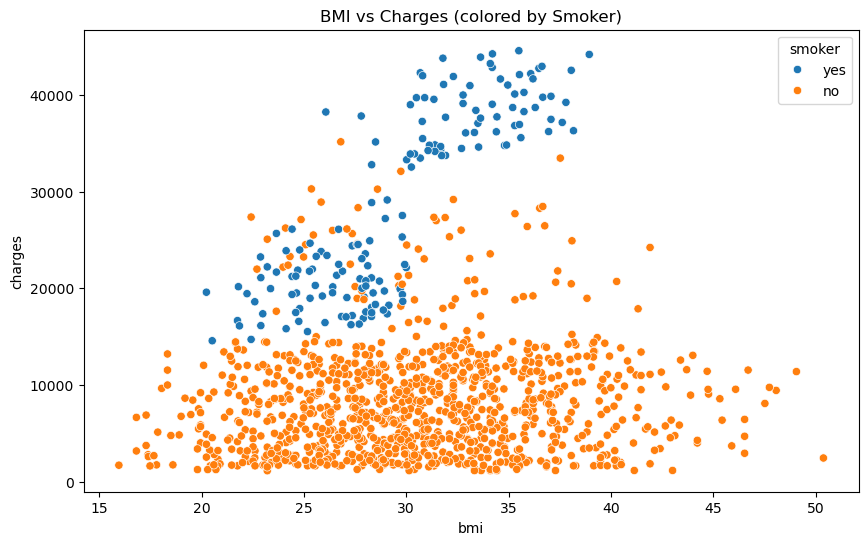

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="bmi", y="charges", hue="smoker", data=df_clean)
plt.title("BMI vs Charges (colored by Smoker)")
plt.show()

For non-smokers, the relationship is not very strong.
But smokers with high BMI (obesity) have extremely high costs → the combination of smoking + high BMI makes the costs skyrocket.

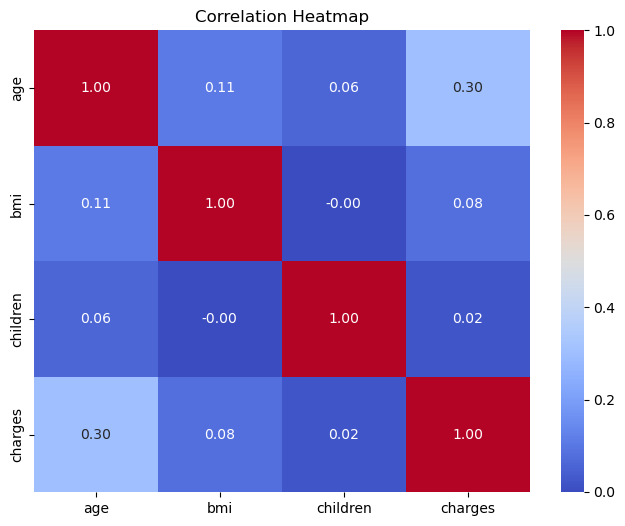

In [22]:
plt.figure(figsize=(8,6))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Summary of insights:

Smoking is the biggest cost factor.
Age and BMI also have an effect, but less than smoking.
Gender and region have almost no effect.
Modeling can be done very well by focusing on age, BMI, and smoker.

In [23]:
df_encoded = pd.get_dummies(df_clean, columns=["sex", "smoker", "region"], drop_first=True)

X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
lin_model = LinearRegression()

In [26]:
lin_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [27]:
lin_pred = lin_model.predict(X_test)

In [28]:
MAE = mean_absolute_error(y_test, lin_pred)

In [29]:
MAE

3591.337724925742

In [30]:
MSE = np.sqrt(mean_squared_error(y_test, lin_pred))

In [31]:
print(MSE)

5861.055309854262


In [32]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)

In [33]:
rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
rf_pred = rf.predict(X_test)

In [35]:
MAE = mean_absolute_error(y_test, rf_pred)

In [36]:
MAE

2620.979223796242

In [37]:
MSE = np.sqrt(mean_squared_error(y_test, rf_pred))

In [38]:
print(MSE)

5292.094626350001


In [39]:
gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)

In [40]:
gbr.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


In [41]:
gbr_pred = gbr.predict(X_test)

In [42]:
MAE = mean_absolute_error(y_test, gbr_pred)

In [43]:
MAE

2820.661381731739

In [44]:
MSE = np.sqrt(mean_squared_error(y_test, rf_pred))

In [45]:
print(MSE)

5292.094626350001


In [46]:
param_grid = {
    "n_estimators": [200, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5]
}

grid_search = GridSearchCV(estimator=gbr,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           scoring="neg_mean_squared_error",
                           verbose=2)

In [47]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], 'min_samples_leaf': [1, 3, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [48]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 500}

In [49]:
gs_pred = grid_search.predict(X_test)

In [50]:
MAE = mean_absolute_error(y_test, gs_pred)

In [51]:
MAE

2387.588134893915

In [52]:
MSE = np.sqrt(mean_squared_error(y_test, gs_pred))

In [53]:
print(MSE)

4910.416031145403


In [54]:
param_dist = {
    "n_estimators": randint(200, 1000),
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(3, 6),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10)
}

random_search = RandomizedSearchCV(estimator=gbr,
                                   param_distributions=param_dist,
                                   n_iter=30,       
                                   cv=3,
                                   n_jobs=-1,
                                   scoring="neg_mean_squared_error",
                                   random_state=42,
                                   verbose=2)


In [55]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,GradientBoost...ndom_state=42)
,param_distributions,"{'learning_rate': <scipy.stats....0026384B27440>, 'max_depth': <scipy.stats....002638549C140>, 'min_samples_leaf': <scipy.stats....0026385453EF0>, 'min_samples_split': <scipy.stats....0026385451130>, ...}"
,n_iter,30
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [56]:
random_search.best_params_

{'learning_rate': np.float64(0.03391884918766034),
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 204}

In [57]:
rs_pred = random_search.predict(X_test)

In [58]:
MAE = mean_absolute_error(y_test, rs_pred)

In [59]:
MAE

2484.170132231995

In [60]:
MSE = np.sqrt(mean_squared_error(y_test, rs_pred))

In [61]:
print(MSE)

5037.969602000272


In [66]:
best_gb = random_search.best_estimator_

In [67]:
importances = best_gb.feature_importances_
features = X.columns

feat_imp = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

C:\Users\Parsa\AppData\Local\Temp\ipykernel_9468\3494009817.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")


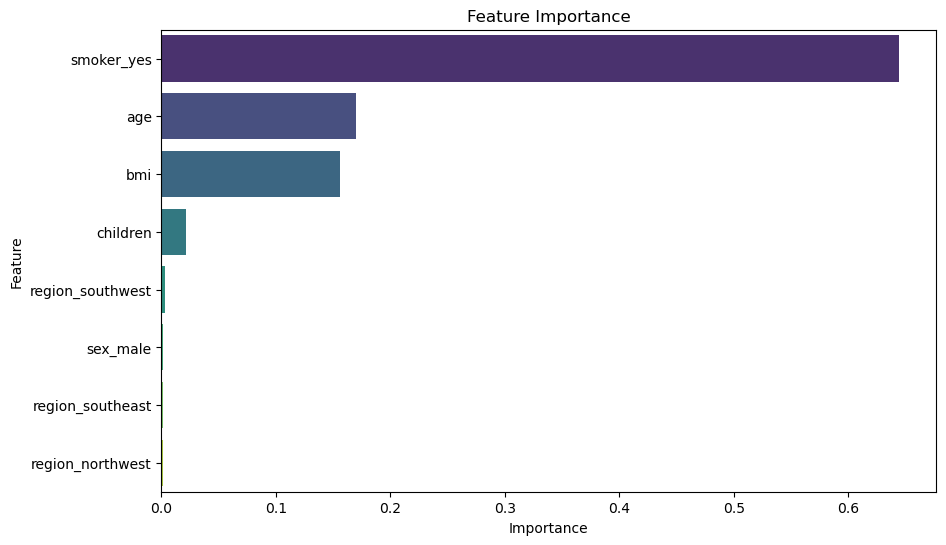

In [68]:
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
plt.title("Feature Importance")
plt.show()

In [74]:
X_train_shap = X_train.astype(float)
X_test_shap = X_test.astype(float)

explainer = shap.Explainer(best_gb, X_train_shap)
shap_values = explainer(X_test_shap, check_additivity=False)


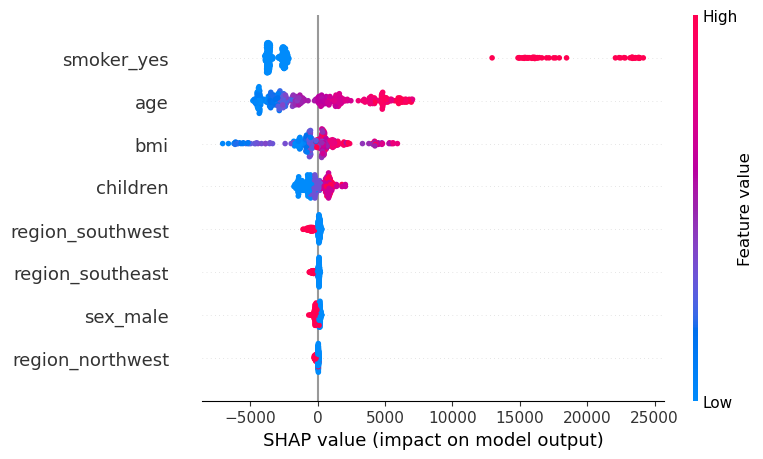

In [75]:
shap.summary_plot(shap_values, X_test_shap)

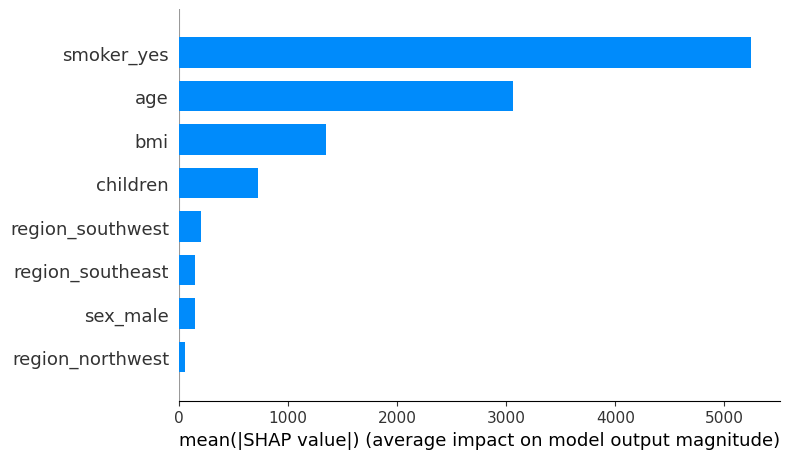

In [76]:
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")

In [78]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(best_gb, X, y, cv=kf, scoring="r2")

mae_scores = -cross_val_score(best_gb, X, y, cv=kf, scoring="neg_mean_absolute_error")

rmse_scores = np.sqrt(-cross_val_score(best_gb, X, y, cv=kf, scoring="neg_mean_squared_error"))

In [80]:
print("Mean R²:", np.mean(r2_scores))

print("Mean MAE:", np.mean(mae_scores))

print("Mean RMSE:", np.mean(rmse_scores))

Mean R²: 0.7897710689419497
Mean MAE: 2290.6432356075456
Mean RMSE: 4273.258518586748
